In [1]:
import numpy as np, itertools
import tools21cm as t2c, numpy as np
import matplotlib.pyplot as plt

from scipy import special
from tqdm import tqdm
from ipywidgets import interact

import astropy.units as u
import astropy.constants as cst
from astropy.cosmology import Planck18 as cosmo

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
2024-02-25 16:22:20.338609: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-25 16:22:20.582008: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-25 16:22:20.582157: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-25 16:22:20.620641: E external/local

## Basic Interferometry
It turn out that a simple two antenna radio interferometer can be mathematically represented by a correlation operation, as the signal detectect by two separated radio anteannas

Let assume that we have two antennas located at $\vec{r}_1$ and $\vec{r}_2$. The electric field from a source in the sky $ I_{\rm sky}(\vec{r}) \equiv E_\nu(\vec{r})$

, with the time delay of the signal reaching due to the shift . 
$ \tau $

$$ V_\nu (\vec{r}_1,\,\vec{r}_2) = \left<I_\nu(\vec{r}) \right>$$

## Basic of Radio Interferometry
Interferometric radio telescope observation is a technique used to enhance the resolution and sensitivity of observations. It involves combining signals from multiple separate telescopes or antenna elements and <i>"virtually simulate"</i> a telescope that can capture larger wavelength. 

This technique is based on the principle of interferometry, where the signals collected by separate telescopes are combined and analyzed to extract detailed information about astronomical objects.

<img src="images/interferometry.png" alt="Drawing" style="width: 500px;"/>

## The geometrical delay
In radio interferometry, antennas observe a source in the sky from different positions. Therefore the resulting signals, detected by each antennas, will arrive at different times due to their varying distances from the source.

This delay is referred as the geometrical delay, $\tau$, and it refers to the time delay of a radio wave emitted from a source toward two antennas due to their separating distance, also referred as baseline, $ \mathbf{b} $.

$$ \tau = \frac{\mathbf{b} \cdot \mathbf{s}}{c} $$

Where:
- $ \tau $ is the geometrical delay,
- $ \mathbf{b} $ is the baseline vector representing the separation between two antennas,
- $ \mathbf{s} $ is the direction vector from the source to the phase center,
- $ c $ is the speed of light.

This delay is a critical consideration in interferometric observations because it affects the coherence of the signals received by the antennas, which in turn impacts the quality of the interferometric data. By precisely measuring and accounting for these geometrical delays, interferometric data can be properly calibrated to accurately reconstruct images of astronomical objects with high spatial resolution.


Geometrical delay is relevant in radio interferometry for the following reasons:

- __Baseline Lengths:__ In an interferometric array, each pair of antennas forms a baseline. The length of each baseline determines the spatial resolution and sensitivity of the interferometric observations. Longer baselines provide higher spatial resolution but may introduce larger geometrical delays.
 - __Delay Calculation:__ The geometrical delay for each baseline is calculated based on the difference in the distances traveled by the signal from the source to each antenna. This calculation takes into account the geometry of the array, the position of the source in the sky, and the Earth's rotation.
 - __Delay Compensation:__ Geometrical delays need to be compensated during data processing to ensure accurate interferometric measurements. Delay compensation techniques, such as fringe tracking and phase correction, are used to align the signals received by different antennas properly.
 - __Wide-field Imaging:__ Geometrical delays become more complex when observing extended sources or large fields of view. In such cases, corrections for the variation in delay across the field of view are necessary to accurately reconstruct images of the sky.
 - __Phase Referencing:__ In some interferometric observations, a nearby calibrator source with a known position is used as a reference to correct for geometrical delays. By periodically observing the calibrator, astronomers can track and compensate for changes in the delay introduced by the Earth's rotation and atmospheric effects.

## Visibility explained

$$ V(\vec b, \nu) = \int{A(\hat s)\cdot I(\hat s)\cdot e^{-2\pi i \vec b \cdot \hat s / \lambda} d\Omega} $$

where here:
 - $\hat s$ is a normalized vector pointing to the sky image
 - $A(\hat s)$ is , also referred as primary beam

Let consider two dish antennas 1 and 2 at a give distance $|\mathbf{b}|$ to each other. As we mentioned above there would be some time delay, $\tau$, between a signal reached by antenna 1 and antenna 2

In [2]:
# define a 1D sky and get RA coordinate
thet = np.linspace(-np.pi/2, np.pi/2, 2048)

# define a observed frequency
freq = 200. * u.MHz

def plt_fringe(pointing, baseline, FoV):
    # baseline in metre units
    baseline *= u.m

    offset = 10 # needed just for a visualy nicer plot
    
    # calculate fringe pattern
    fringe_pattern = np.exp(-2j * np.pi * np.sin(thet)  * (baseline / cst.c * freq).cgs.value)
    
    # define the beam    
    beam_pattern = offset/3 * np.exp(-(thet+pointing)**2 / (2 * FoV**2)) # Gaussian beam pattern

    # plot fringe pattern
    ax2 = plt.subplot(111, projection='polar')    
    plt.polar(thet, fringe_pattern.real+offset)
    
    # plot the combination with the beam
    plt.polar(thet, beam_pattern * fringe_pattern.real+offset)
    
    # plot the beam
    plt.polar(thet, beam_pattern)
    
    ax2.set_theta_offset(np.pi/2)
    #ax2.set_yticks([])
    ax2.set_thetamin(-90), ax2.set_thetamax(90)
    plt.show(), plt.clf()
    
interact(plt_fringe, pointing=(-np.pi/2,np.pi/2), baseline=(0, 50), FoV=(0.05, 0.5))

interactive(children=(FloatSlider(value=0.0, description='pointing', max=1.5707963267948966, min=-1.5707963267…

<function __main__.plt_fringe(pointing, baseline, FoV)>

## Simulate a 1D Inteferometric Telescope
Here we will create a simulation of 

In [5]:
# define a 1D sky and get RA coordinate
thet = np.linspace(-np.pi/2, np.pi/2, 2048)

# define a observed frequency
freq = 100. * u.MHz
bl = 8 * u.m

# position of the two sources
mean_A = thet[768]
mean_B = thet[-768]
std_A = 0.05
std_B = 0.1

# create two gaussian sources
source_A = (1 / (std_A * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((thet - mean_A) / std_A) ** 2)
source_B = (1 / (std_B * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((thet - mean_B) / std_B) ** 2)

# Combine the two distributions by adding their PDFs
I_sky = source_A + source_B

# calculate fring patter for the two antennas
fringe_pattern = np.exp(-2j * np.pi * np.sin(thet) * (bl / cst.c * freq).cgs.value)

(None, None)

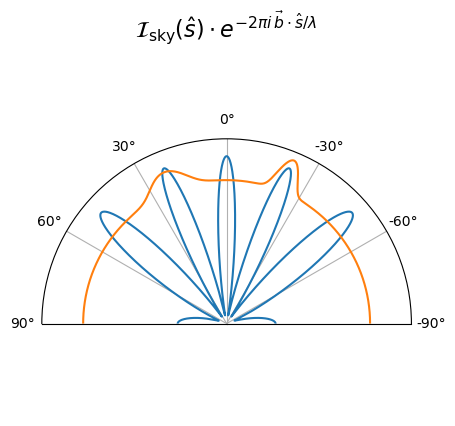

In [6]:
# plot fringe pattern and sky model
ax = plt.subplot(111,projection='polar')
ax.set_title(r'$\mathcal{I}_{\rm sky}(\hat s )\cdot e^{-2\pi i\, \vec b \cdot \hat s / \lambda}$', fontsize=16)
plt.polar(thet, fringe_pattern.real)
plt.polar(thet, np.log10(I_sky.real+5))
ax.set_theta_offset(np.pi/2)
ax.set_yticks([])
ax.set_thetamin(-90), ax.set_thetamax(90)

Now let assume we have a series of antenna at given distance to each other

In [7]:
# define 
baselines = np.linspace(0, 200, 250) * u.m

# visibilities
V = [] 

# loop trought different baseline
for bl in baselines:
    # calculate fringe patter
    fringe_pattern = np.exp(-2j * np.pi * np.sin(thet) *( bl  / cst.c * freq).cgs.value)
    
    # discrete integration
    V.append(np.sum(I_sky * fringe_pattern))


In [8]:
UMAX = 250
URES = 0.5
USIZE = int(UMAX / URES)

u_coord = np.linspace(-UMAX, UMAX, USIZE, endpoint=False)
u_coord = np.fft.fftshift(u_coord)
u_plane = np.zeros(USIZE, dtype=complex)
u_sampl = np.zeros(USIZE, dtype=complex)

for bl, vis in zip(baselines, V):
    u_bin = int(np.around((bl * freq / cst.c).cgs.value / URES))
    u_plane[u_bin] += vis
    u_sampl[u_bin] += 1
    u_plane[-u_bin] += vis.conj()
    u_sampl[-u_bin] += 1
u_plane /= np.where(u_sampl > 0, u_sampl, 1)

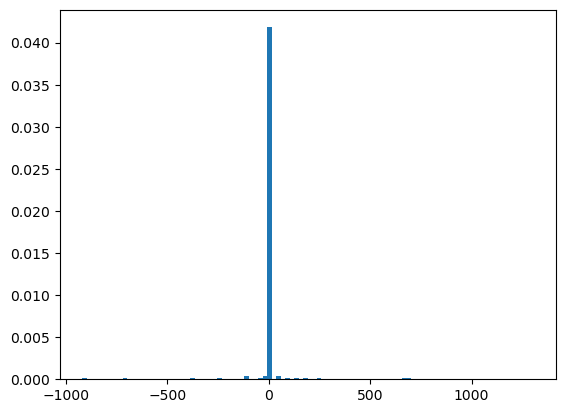

In [11]:
plt.hist(u_plane.real, bins=100, density=True);

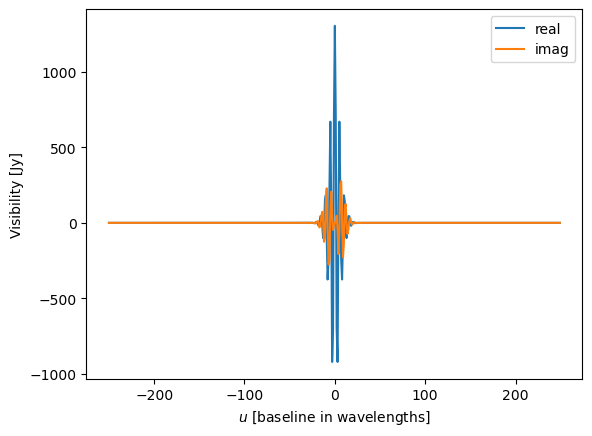

In [12]:
plt.figure()
plt.plot(np.fft.fftshift(u_coord), np.fft.fftshift(u_plane.real), label='real')
plt.plot(np.fft.fftshift(u_coord), np.fft.fftshift(u_plane.imag), label='imag')
plt.ylabel('Visibility [Jy]')
plt.xlabel('$u$ [baseline in wavelengths]')
_ = plt.legend(loc='best')

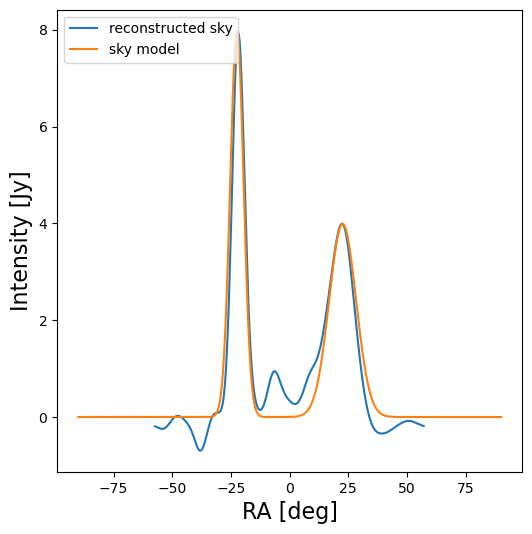

In [13]:
I_sky_reconstruct = np.fft.ifft(u_plane)
x = np.fft.fftfreq(USIZE, URES)
plt.figure(figsize=(6,6))
plt.plot(np.rad2deg(np.fft.fftshift(x)), np.exp(-1)*np.fft.fftshift(I_sky_reconstruct), label='reconstructed sky')
plt.plot(np.rad2deg(thet), I_sky, label='sky model')
plt.ylabel('Intensity [Jy]', fontsize=16), plt.xlabel('RA [deg]', fontsize=16)
plt.legend(loc=2)
plt.show()

## Exercise
Now try yourself to create an interferometry telescope simulation in 2D. Use the gaussian point source defined here below.

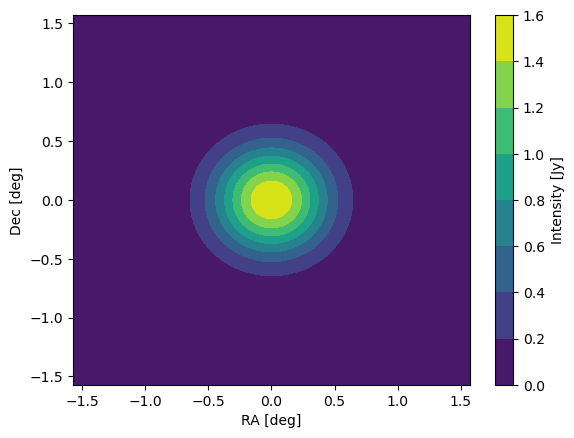

In [404]:
# define a 1D sky and get RA coordinate
thet = np.linspace(-np.pi/2, np.pi/2, 2048)

def gaussian_2d(x, y, mean, cov):
    """ a simple 2D gaussian distribution """
    x_diff = x - mean[0]
    y_diff = y - mean[1]
    inv_cov = np.linalg.inv(cov)
    exponent = -0.5 * (x_diff**2 * inv_cov[0, 0] + y_diff**2 * inv_cov[1, 1] + 2 * x_diff * y_diff * inv_cov[0, 1])
    prefactor = 1 / (2 * np.pi * np.sqrt(np.linalg.det(cov)))
    return prefactor * np.exp(exponent)

# Define parameters
mu = np.array([0, 0])  # Mean
sigma = np.array([[0.1, 0], [0, 0.1]])  # Covariance matrix

# Create a grid of points
thet_X, thet_Y = np.meshgrid(thet, thet)
pos = np.dstack((thet_X, thet_Y))

# Calculate the probability density function (PDF) of the Gaussian distribution at each point
I_sky = gaussian_2d(x=thet_X, y=thet_Y, mean=mu, cov=sigma)

# Plot the 2D Gaussian distribution
plt.contourf(thet_X, thet_Y, I_sky, cmap='viridis')
plt.ylabel('Dec [deg]'), plt.xlabel('RA [deg]')
plt.colorbar(label='Intensity [Jy]')
plt.show()

## Telescope layout
Her we read and visualise the layout of the SKA-Low telescope. The coordinates of the different station are generally give in the reference frame of the centre of the layout, often referred as $xyz$-coordinate, in meter units.

In our case we are considering the <i>SKA-Low 2016</i> configuration located in the West of Australia.

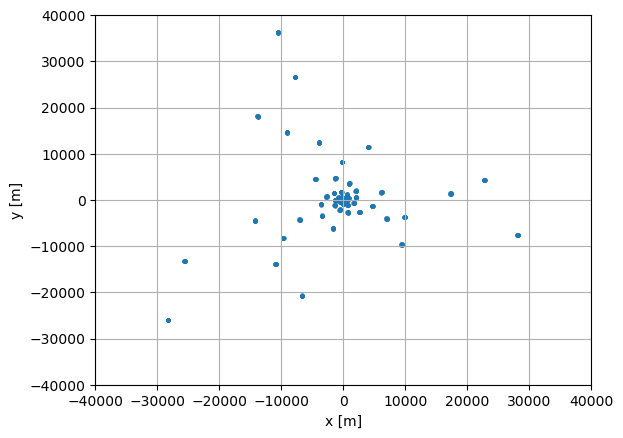

(None, None)

<Figure size 640x480 with 0 Axes>

In [25]:
#layout = np.loadtxt('skalow_layout.txt', usecols=(0,1))
layout = 

plt.scatter(layout[:,0], layout[:,1], s=5, color='tab:blue')
plt.grid(), plt.xlabel('x [m]'), plt.ylabel('y [m]')
plt.xlim(-40000, 40000), plt.ylim(-40000, 40000)
plt.show(), plt.clf()

The baselines, $ \mathbf{b} $, is the distance between a pair of stations/antennas (i.e., all possible antenna combinations). For a given number of stations/antennas, $N_{\rm ant}$, we can have a total of baselines:

$$N_B = \frac{N_{\rm ant}\cdot (N_{\rm ant} - 1)}{2} $$

In [26]:
N_ant = layout.shape[0]
N_B = int(N_ant*(N_ant-1)/2)

print('N_ant =', N_ant)
print('N_B =', N_B)

N_ant = 512
N_B = 130816


## The uv-coordinates
To obtain the corresponding $uv$-coordinates from the $XYZ$-coordinates (cartesian) of the antennas on Earth in radio interferometry, you need to calculate the baseline vectors between pairs of antennas. 

Each baseline probes a particular Fourier mode of the sky signal, therefore all the baselines of an interferometer then provides information about multiple Fourier modes of the sky. 

In [27]:
# define observed frequency and corresponding wavelenght
freq = 200*u.MHz
lam = (cst.c/freq).to('m')

# get pair of 
pair_comb = list(itertools.combinations(range(N_ant), 2))

assert np.shape(pair_comb)[0] == N_B


baselines = np.empty((N_B, 2))

for i in tqdm(range(N_B)):
    ii, jj = pair_comb[i]
    
    # calculate the distance between antennas
    uv = (layout[ii]-layout[jj])/lam
    baselines[i] = uv

# add units
baselines /= u.m

100%|████████████████████████████████| 130816/130816 [00:01<00:00, 97540.69it/s]


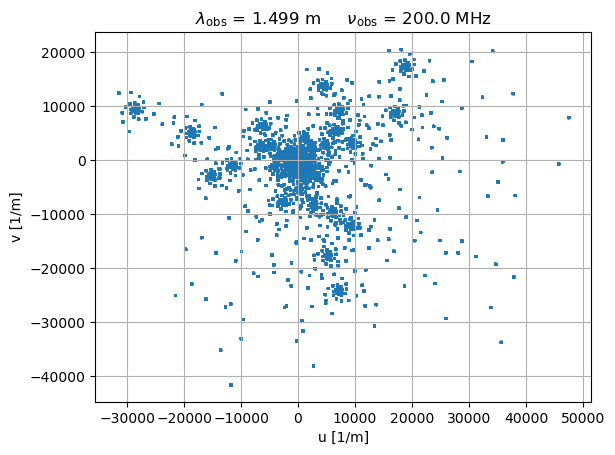

(None, None)

<Figure size 640x480 with 0 Axes>

In [28]:
# Plot the baselines in the uv-plane
plt.title(r'$\lambda_{\rm obs}$ = %.3f %s     $\nu_{\rm obs}$ = %.1f %s' %(lam.value, lam.unit, freq.value, freq.unit))
plt.scatter(baselines[:,0], baselines[:,1], s=1, color='tab:blue')
plt.grid(), plt.xlabel('u [1/m]'), plt.ylabel('v [1/m]')
plt.show(), plt.clf()